Here we will build a topic model with Genism. Latent Dirichlet Allocation (LDA) is the algorithm we will be using. We will be doing unstructured classification with the customer complaint narrative column within the dataset we've previously prepared in the DataExplore notebook. We will be doing this to create our own caterogies from the data and see just how accurate the existing categories are. The categories will be defined by creating topics (a collection of reoccurring keywords are used to identify a topic).

In [1]:
# Make sure to have nltk and stopwords downloaded
import nltk; nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danrl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Import needed packages

import re
import numpy
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format="%(asctime)s: %(levelname)s : %(message)s", level=logging.ERROR)

import warnings 
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# Get data
df = pd.read_csv('../../student-loan-complaints-data/text_analysis_data.csv')
df.head()

,Date received,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,Tags,Company response to consumer,Timely response?,Consumer disputed?,month,year
0,2020-05-19,Private student loan,Dealing with your lender or servicer,Received bad information about your loan,When I was applying for my loan my XXXX accoun...,"Figure Technologies, Inc",NJ,None,Closed with explanation,Yes,NaN,5,2020
1,2020-02-06,Federal student loan servicing,Incorrect information on your report,Account status incorrect,I'm on a deferred payment plan t never ; late,"Nelnet, Inc.",TX,None,Closed with explanation,Yes,NaN,2,2020
2,2020-02-08,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,I have attempted multiple times to contact FED...,AES/PHEAA,KY,None,Closed with non-monetary relief,Yes,NaN,2,2020
3,2020-01-21,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I was divorced in 2004 and I agreed to take th...,AES/PHEAA,OK,None,Closed with explanation,Yes,NaN,1,2020
4,2019-12-04,Federal student loan servicing,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,This particular account situation that is late...,AES/PHEAA,FL,None,Closed with explanation,Yes,NaN,12,2019


Now that we've imported the necessary packages we will prepare the data to build and feed into the model.

In [5]:
# A function to preprocess all rows in a dataframe
def preprocess_data(data):
    # Change all text to lowercase
    data = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove puctuation
    data = data.str.replace("[^\w\s]","")
    
    # Remove stopwords
    from nltk.corpus import stopwords
    stop = stopwords.words("english")
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Remove common words
    freq = pd.Series(" ".join(data).split()).value_counts()[:10]
    freq = list(freq.index)
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    
    # Lemmatization
    from textblob import Word
    data = data.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    # Return transformed data
    return data, freq

# Return the data as a list
data, freqWords = preprocess_data(df["Consumer complaint narrative"])

In [6]:
print(freqWords)

['xxxx', 'loan', 'loans', 'payment', 'payments', 'xxxxxxxx', 'would', 'navient', 'student', 'interest']


In [7]:
# Tokenize the data
data = [sub.split() for sub in data] 
print(data[:3])

[['applying', 'account', 'correctly', 'communicate', 'issue', 'offer', '025', 'rate', 'deduction', 'autopay', 'showing', 'account', 'told', 'go', 'application', 'anyway', 'account', 'opened', 'could', 'add', 'autopay', 'receive', 'discount', 'way', 'since', 'account', 'opened', 'called', 'call', 'center', 'least', '4', 'time', 'trying', 'receive', 'autopay', 'discount', 'first', '3', 'time', 'told', 'going', 'applied', 'still', 'seen', 'additionally', 'last', 'time', 'called', '3', 'week', 'ago', 'asked', 'speak', 'manager', 'told', 'take', '10', 'day', 'get', 'back', 'still', 'yet', 'hear', 'back', '15', 'business', 'day', 'later', 'told', 'receiving', 'autopay', 'discount', 'receiving', 'opened', 'account', 'company', 'lying', 'rate', 'going', 'receive', 'dont', 'autopay', 'initiate', '2', 'autopays', 'go', 'far', 'additional', 'issue', 'told', 'rate', 'going', 'based', '1', 'month', 'libor', 'rate', 'published', 'wsj', 'month', 'none', 'rate', 'received', 'thus', 'far', 'match', 'ra

Now that we've cleaned and tokenized the data we need to create bigrams and trigrams. Bigrams are two words frequently seen paired together, trigrams are the same but with three words. We will use Gensim's Phrases model to build the bigrams and trigrams.

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['applying', 'account', 'correctly', 'communicate', 'issue', 'offer', '025', 'rate', 'deduction', 'autopay', 'showing', 'account', 'told', 'go', 'application', 'anyway', 'account', 'opened', 'could', 'add', 'autopay', 'receive', 'discount', 'way', 'since', 'account', 'opened', 'called', 'call', 'center', 'least', '4', 'time', 'trying', 'receive', 'autopay', 'discount', 'first', '3', 'time', 'told', 'going', 'applied', 'still', 'seen', 'additionally', 'last', 'time', 'called', '3', 'week', 'ago', 'asked', 'speak', 'manager', 'told', 'take', '10', 'day', 'get', 'back', 'still', 'yet', 'hear', 'back', '15', 'business', 'day', 'later', 'told', 'receiving', 'autopay', 'discount', 'receiving', 'opened', 'account', 'company', 'lying', 'rate', 'going', 'receive', 'dont', 'autopay', 'initiate', '2', 'autopays', 'go', 'far', 'additional', 'issue', 'told', 'rate', 'going', 'based', '1', 'month', 'libor', 'rate', 'published', 'wsj', 'month', 'none', 'rate', 'received', 'thus_far', 'match', 'rate',

In [9]:
# As we can see above, out attempt at lemmatizing the data didn't work. We will just try it again.
# Here we are defining functions for bigrams, trigrams, and lemmatizing the data

def make_bigrams(data):
    return [bigram_mod[doc] for doc in data]

def make_trigrams(data):
    return [trigram_mod[bigram_mod[doc]] for doc in data]

def lemmatization(data, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    complaints_out = []
    for complaint in data:
        doc = nlp(" ".join(complaint))
        complaints_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return complaints_out

In [10]:
# Now we call the functions we build above
data_words_bigrams = make_bigrams(data)
nlp = spacy.load("en", disable=["parser", "ner"])
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['apply', 'account', 'correctly', 'communicate', 'issue', 'offer', 'rate', 'deduction', 'autopay', 'show', 'account', 'tell', 'go', 'application', 'account', 'open', 'could', 'add', 'autopay', 'receive', 'discount', 'way', 'account', 'open', 'call', 'center', 'least', 'time', 'try', 'receive', 'autopay', 'discount', 'first', 'time', 'tell', 'go', 'apply', 'still', 'see', 'additionally', 'last', 'time', 'call', 'week', 'ask', 'manager', 'tell', 'take', 'day', 'get', 'back', 'still', 'yet', 'hear', 'back', 'business', 'day', 'later', 'tell', 'receive', 'autopay', 'discount', 'receiving', 'open', 'account', 'company', 'lie', 'rate', 'go', 'receive', 'autopay', 'autopay', 'go', 'far', 'additional', 'issue', 'tell', 'rate', 'go', 'base', 'month', 'rate', 'publish', 'month', 'none', 'rate', 'receive', 'thus_far', 'match', 'rate', 'really', 'know', 'try', 'contact', 'many', 'time', 'people', 'phone', 'seem', 'helpful', 'time', 'talk', 'seem', 'get', 'do']]


At this point we've created some bi_grams and tri_grams. Now we need to create a dictionary and corpus that's needed for topic modeling.

In [11]:
# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
complaints = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(complaint) for complaint in complaints]

print("Corpus format: (word_id, work_frequency)")
print(corpus[:1])
print()
print("Readable version of term-frequency:")
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

Corpus format: (word_id, work_frequency)
[[(0, 5), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 6), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 2), (25, 5), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 6), (45, 1), (46, 5), (47, 1), (48, 1), (49, 2), (50, 1), (51, 2), (52, 1), (53, 1), (54, 5), (55, 1), (56, 5), (57, 2), (58, 1), (59, 1), (60, 1)]]

Readable version of term-frequency:
[[('account', 5), ('add', 1), ('additional', 1), ('additionally', 1), ('application', 1), ('apply', 2), ('ask', 1), ('autopay', 6), ('back', 2), ('base', 1), ('business', 1), ('call', 2), ('center', 1), ('communicate', 1), ('company', 1), ('contact', 1), ('correctly', 1), ('could', 1), ('day', 2), ('deduction', 1), ('discount', 3), ('do', 1), ('far', 1), ('first', 1), ('get', 2

Now that we've prepared the data and have everything we need to train the LDA model, we will build it. 

In [12]:
# Building the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto",
                                           per_word_topics=True)

In [13]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.196*"repay" + 0.170*"bankruptcy" + 0.132*"daughter" + 0.058*"timely" + '
  '0.039*"daily" + 0.033*"xxxxxxxxxxxxxxxx" + 0.030*"official" + 0.028*"split" '
  '+ 0.028*"overpay" + 0.025*"supply"'),
 (1,
  '0.149*"information" + 0.094*"contact" + 0.067*"company" + 0.066*"number" + '
  '0.062*"provide" + 0.045*"regard" + 0.031*"attempt" + 0.028*"name" + '
  '0.024*"give" + 0.023*"list"'),
 (2,
  '0.206*"receive" + 0.148*"send" + 0.097*"letter" + 0.096*"request" + '
  '0.095*"email" + 0.066*"state" + 0.040*"form" + 0.032*"mail" + '
  '0.030*"response" + 0.025*"write"'),
 (3,
  '0.234*"default" + 0.190*"collection" + 0.108*"nelnet" + 0.094*"agency" + '
  '0.085*"agreement" + 0.042*"education" + 0.034*"rehabilitation" + '
  '0.025*"dept" + 0.024*"mine" + 0.013*"tax"'),
 (4,
  '0.102*"plan" + 0.100*"repayment" + 0.084*"income" + 0.066*"program" + '
  '0.053*"forgiveness" + 0.042*"year" + 0.040*"base" + 0.038*"qualify" + '
  '0.034*"service" + 0.028*"pslf"'),
 (5,
  '0.469*"account" + 

In [14]:
# Compute perplexity
print("Perplexity:", lda_model.log_perplexity(corpus))

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence score:", coherence_lda)

Perplexity: -9.206020080130664

Coherence score: 0.38448119717595325


We now have a baseline. We will measure the performance of this model mostly using the coherence score. Which our baseline coherence score is 0.38, which is pretty bad (the higher the better). But atleast we have a baseline and we can start working on improving the mdoel from here. 

The model has been built and can be viewed above. The words displayed above (a couple spaces above are the top words and its weight used to determine that specific topic. There are 20 topics total (0 - 19).

Now we will visualize the topics and their keywords using pyLDAvis

In [15]:
pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

C:\Users\danrl\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Using the visualization above:
On the left is the topics, the larger the bubble the more popular the topic. The closer the bubble is to another bubble the more similar they are. Moving the cursor over a bubble will show new words and bars on the side. These words are the keywords for that selected topic. 

Now we will be using a slightly more accurate version of the LDA model, LDA Mallet Model. The Mallet model will be slightly more precise.

import os
os.environ.update({"MALLET_HOME": r"C:/Users/danrl/student-loan-complaints/mallet-2.0.8/"})

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'student-loan-complaints/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print("\nCoherence Score: ", coherence_ldamallet)

The code above is set to build an LDA Mallet Model, but it's not working. So, as of right now we will just use the normal LDA Model. But to find the best number of topics we will create a function that builds models with several different numbers of topics and we will return lists of the models with the coherence score outputted by that model. This way we can compare them and see what number of topics outputs the highest coherence scores.

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    Parameters:
    -----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: List of input texts
    limit: Max num of topics
    
    Returns:
    --------
    model_list: List of LDA topic models
    coherence_values: Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto",
                                           per_word_topics=True)
        
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2_word=id2word)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

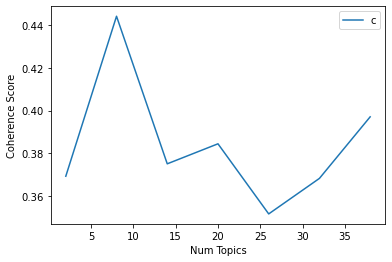

In [21]:
# Graph the num_topics compared to coherence_value

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m} has Coherence Value of {round(cv, 4)}")

Num Topics = 2 has Coherence Value of 0.3693
Num Topics = 8 has Coherence Value of 0.4441
Num Topics = 14 has Coherence Value of 0.3751
Num Topics = 20 has Coherence Value of 0.3845
Num Topics = 26 has Coherence Value of 0.3517
Num Topics = 32 has Coherence Value of 0.3683
Num Topics = 38 has Coherence Value of 0.3971


As we can see above, the model performs a lot better when we have around 8 topics, so we will choose 8 to be our number of topics. It gives the Coherence Value of 0.4441, which is still really low so we will need to find some other ways of tuning the model to get a better performance. 

While we are here, lets take a look at the topics chosen for this model.

In [24]:
# Select the best model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.040*"school" + 0.023*"private" + 0.023*"take" + 0.022*"help" + '
  '0.016*"pay" + 0.016*"job" + 0.016*"go" + 0.016*"never" + 0.014*"get" + '
  '0.012*"money"'),
 (1,
  '0.036*"debt" + 0.028*"default" + 0.026*"file" + 0.024*"collection" + '
  '0.021*"company" + 0.020*"complaint" + 0.020*"provide" + 0.018*"borrower" + '
  '0.017*"agency" + 0.016*"claim"'),
 (2,
  '0.126*"receive" + 0.086*"send" + 0.057*"letter" + 0.056*"email" + '
  '0.051*"request" + 0.049*"state" + 0.029*"document" + 0.019*"mail" + '
  '0.018*"address" + 0.017*"response"'),
 (3,
  '0.087*"plan" + 0.085*"repayment" + 0.069*"income" + 0.055*"forbearance" + '
  '0.045*"application" + 0.037*"submit" + 0.034*"base" + 0.032*"process" + '
  '0.030*"form" + 0.023*"paperwork"'),
 (4,
  '0.067*"year" + 0.042*"make" + 0.037*"time" + 0.030*"program" + 0.028*"work" '
  '+ 0.022*"option" + 0.020*"forgiveness" + 0.019*"service" + 0.014*"month" + '
  '0.014*"qualify"'),
 (5,
  '0.067*"call" + 0.053*"tell" + 0.032*"say" + 0.0

I'm going to keep this notebook as it is as a base model, duplicate it, and work on the duplicated version to fine tune a few things.